In [11]:
!pip install rouge

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing all necessary libraries
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import reuters
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk.data
import math
import re
import nltk
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge 
import seaborn as sns
import matplotlib.pyplot as plt
import string
nltk.download('all')

In [14]:
summary_threshold = 5  # number of sentences in final summary
stop_words = stopwords.words('english') #getting all the stopwords
stemmer = PorterStemmer()  #using PorterStemmer for stemming purposes

In [15]:
class Summarizer():
    #taking in articles and extracting the headline and body to place them in a list
    def __init__(self, article): #constructor
      self._articles = []
      for doc in article:
            with open(doc) as f:
                headline = f.readline() #first line of article is the headline
                url = f.readline() #second line of article is the url
                body = f.read().replace('\n', ' ') #read the remaining of the article and replace the empty lines with a whitespace
                #if headline and body is not empty, then we assign the values into 'articles' list
                if not self.valid_input(headline, body):
                    self._articles.append((None, None))
                    continue
                self._articles.append((headline, body))
 
    #check if headline and body has any text or not
    def valid_input(self, headline, article_text):
        return headline != '' and article_text != ''

    #perform tokenization and stemming (using PorterStemmer)  
    def tokenize_and_stem(self, text):
        tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        filtered = []
        #filter out numeric tokens, raw punctuation, etc.
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered.append(token)
        stems = [stemmer.stem(t) for t in filtered]
        return stems

    #building tf_idf score in a matrix for each word in the Reuters corpus
    def build_TFIDF_model(self):
        token_dict = {}
        #getting the name of the article
        for article in reuters.fileids():
            token_dict[article] = reuters.raw(article) 
        # Use TF-IDF to determine frequency of each word in our article, relative to the word frequency distributions in corpus of 10.8k Reuters news articles.
        self._tfidf = TfidfVectorizer(tokenizer=self.tokenize_and_stem, stop_words='english', decode_error='ignore')
        tdm = self._tfidf.fit_transform(token_dict.values())

    #extracting each sentence from the article
    def split_into_sentences(self, text):
        #identify where each sentence ends
        tok = nltk.data.load('tokenizers/punkt/english.pickle')
        sentences = tok.tokenize(self.remove_smart_quotes(text))
        #consider sentences with a length of more than 10
        sentences = [sent.replace('\n', '') for sent in sentences if len(sent) > 10]
        return sentences

    #function for generating the summary
    def generate_summaries(self):
        #Identifying the number of sentences
        total_num_sentences = 0
        for article in self._articles:
            total_num_sentences += len(self.split_into_sentences(article[1]))
        
        #If article is shorter than the desired threshold, return the original articles
        if total_num_sentences <= summary_threshold:
            return [x[1] for x in self._articles]

        self.build_TFIDF_model()  #build tf-idf score matrix from Reuters corpus
        self._scores = Counter()
        for article in self._articles:
            self.score(article)
        highest_scoring = self._scores.most_common(summary_threshold)

        # Appending highest scoring "representative" sentences, returns as a single summary paragraph and save to text file
        with open("Summary.txt", "w") as fwrite:
          fwrite.write("Headline: \n")
          for article in self._articles:
            fwrite.write(article[0])
          fwrite.write("\nSummary: \n")
          fwrite.write(' '.join([sent[0] for sent in highest_scoring])) 
        return ' '.join([sent[0] for sent in highest_scoring])
    
    #remove smart quotes
    def remove_smart_quotes(self, text):
        return text.replace(u"\u201c","").replace(u"\u201d", "")

    #this function is to assign the sentences in the summary based on its relevance to headline, length, sentence position, word frequencies
    def score(self, article):
        headline = article[0]
        sentences = self.split_into_sentences(article[1])
        frequency_scores = self.frequency_scores(article[1])
        for i, s in enumerate(sentences):
            headline_score = self.headline_score(headline, s) * 1.5
            length_score = self.length_score(self.get_tokens(s)) * 1.0
            position_score = self.position_score(float(i+1), len(sentences)) * 1.0
            frequency_score = frequency_scores[i] * 4
            score = (headline_score + frequency_score + length_score + position_score) / 4.0
            self._scores[s] = score

    #in this function sentences are scored as the sum of their TF-IDF word frequencies.    
    def frequency_scores(self, article_text):
        # Add our document into the model so we can retrieve scores
        response = self._tfidf.transform([article_text])
        feature_names = self._tfidf.get_feature_names() # these are just stemmed words
        word_prob = {}  # TF-IDF individual word probabilities
        for col in response.nonzero()[1]:
            word_prob[feature_names[col]] = response[0, col]

        #taking each sentence score based on its word probability
        sent_scores = []
        for sentence in self.split_into_sentences(article_text):
            score = 0
            sent_tokens = self.tokenize_and_stem(sentence)
            for token in (t for t in sent_tokens if t in word_prob):
                score += word_prob[token]

            # Normalize score by length of sentence, since we later factor in sentence length as a feature
            sent_scores.append(score / len(sent_tokens))
        return sent_scores

    #this function gives sentence a score between 0 to 1 based on percentage of words common to the headline and the article
    def headline_score(self, headline, sentence):
        title_stems = [stemmer.stem(w) for w in headline if w not in stop_words]
        sentence_stems = [stemmer.stem(w) for w in sentence if w not in stop_words]
        count = 0.0
        for word in sentence_stems:
            if word in title_stems:
                count += 1.0
        score = count / len(title_stems)
        return score
  
    #this function gives sentence score between (0,1) based on how close sentence's length is to the ideal length. 
    def length_score(self, sentence):
        len_diff = math.fabs(20 - len(sentence))
        return len_diff/20
      
      
    #split each sentences into tokens
    def get_tokens(self,text):
      lowers = text.lower()
      no_punctuation = lowers.translate(string.punctuation)
      tokens = nltk.word_tokenize(no_punctuation)
      return tokens

    #this function gives a value between (0,1), corresponding to sentence's position in the article.
    #Assuming that sentences at the very beginning and end of the article have a higher weight. 
    def position_score(self, i, size):
        sent_position = i / size
        if 0 < sent_position <= 0.1:
            return 0.17
        elif 0.1 < sent_position <= 0.2:
            return 0.23
        elif 0.2 < sent_position <= 0.3:
            return 0.14
        elif 0.3 < sent_position <= 0.4:
            return 0.08
        elif 0.4 < sent_position <= 0.5:
            return 0.05
        elif 0.5 < sent_position <= 0.6:
            return 0.04
        elif 0.6 < sent_position <= 0.7:
            return 0.06
        elif 0.7 < sent_position <= 0.8:
            return 0.04
        elif 0.8 < sent_position <= 0.9:
            return 0.04
        elif 0.9 < sent_position <= 1.0:
            return 0.15
        else:
            return 0  

In [16]:
import os
os.chdir('/content/drive/MyDrive/Sem 6/NLP Project/')
article = ["article1.txt"] #pushing article into a list
summarized_article = Summarizer(article) #Passing the article into the 'Summarizer' class
s = summarized_article.generate_summaries() #Print the summary
print(s)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

When asked how safe the Pfizer-BioNTech vaccine is for Malaysian use, Dr Kalaiarasu said he would be taking the vaccine himself and asserted that regulatory agencies around the world, including Malaysia’s National Regulatory Pharmaceutical Agency (NPRA), have deemed it safe.  KUALA LUMPUR, Jan 20 — The chairman of the Vaccine Selection Technical Working Group (TWG) today said Malaysians should not avoid being vaccinated against Covid-19 based solely on reported deaths among elderly recipients in Norway. Dr Kalaiarasu, who is also the director of the Institute for Clinical Research Malaysia, additionally pointed out that adverse reactions to the Covid-19 vaccine are occurring at a much lower rate than death caused by the disease. On January 6, the US Centres for Disease Control and Prevention (CDC) reported that allergic reactions to the Pfizer-BioNTech vaccine are occurring at a rate of 11.1 per one million vaccinations. Pfizer conducted its trials on over 40,000 people with ages rangi

In [17]:
bleu_scores=[]

In [18]:
#Quilbot -> https://quillbot.com/summarize

#summary length 3
r = 'Covid-19 vaccine panel chief urges Malaysians not to panic over Norwegian deaths before links proven. It was previously reported 23 chronically ill people, all aged 75 and above, died after they received their vaccination shots. Dr Kalaiarasu Pearisamy said there was still no demonstrable link that the deaths were a direct result of the Pfizer-BioNTech Covid- 19 vaccine.'

print('\nIndividual n-grams for length-3.\n--------------------------------\n1-gram: %f' % sentence_bleu(r, s, weights=(1, 0, 0, 0)))
print('2-gram: %f' % sentence_bleu(r, s, weights=(0, 1, 0, 0)))
print('3-gram: %f' % sentence_bleu(r, s, weights=(0, 0, 1, 0)))
print('4-gram: %f' % sentence_bleu(r, s, weights=(0, 0, 0, 1)))

#The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores
score = sentence_bleu(r, s, weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU Scores: ', score)
bleu_scores.append(score)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Individual n-grams for length-3.
--------------------------------
1-gram: 0.035714
2-gram: 1.000000
3-gram: 1.000000
4-gram: 1.000000
BLEU Scores:  0.4347208719449914


In [19]:
#summary length 5
r = 'Covid-19 vaccine panel chief urges Malaysians not to panic over Norwegian deaths before links proven. It was previously reported 23 chronically ill people, all aged 75 and above, died after they received their vaccination shots. Dr Kalaiarasu Pearisamy said there was still no demonstrable link that the deaths were a direct result of the Pfizer-BioNTech Covid- 19 vaccine. Malaysia is to receive a total of 25 million doses of the vaccine by the end of this year. The death rate in Malaysia is four in every 1,000 infections.'

print('\nIndividual n-grams for length-5.\n---------------------------------\n1-gram: %f' % sentence_bleu(r, s, weights=(1, 0, 0, 0)))
print('2-gram: %f' % sentence_bleu(r, s, weights=(0, 1, 0, 0)))
print('3-gram: %f' % sentence_bleu(r, s, weights=(0, 0, 1, 0)))
print('4-gram: %f' % sentence_bleu(r, s, weights=(0, 0, 0, 1)))

#The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores
score = sentence_bleu(r, s, weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU Scores: ', score)
bleu_scores.append(score)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Individual n-grams for length-5.
---------------------------------
1-gram: 0.036607
2-gram: 1.000000
3-gram: 1.000000
4-gram: 1.000000
BLEU Scores:  0.43741277066697004


In [20]:
#summary length 8
r = "Covid-19 vaccine panel chief urges Malaysians not to panic over Norwegian deaths before links proven. It was previously reported 23 chronically ill people, all aged 75 and above, died after they received their vaccination shots. Dr Kalaiarasu Pearisamy said there was still no demonstrable link that the deaths were a direct result of the Pfizer-BioNTech Covid- 19 vaccine. Malaysia is to receive a total of 25 million doses of the vaccine by the end of this year. The death rate in Malaysia is four in every 1,000 infections of the disease. The Pfizer vaccine has a 95 per cent efficacy rate, according to the Vaccine Selection Technical Working Group (TWG) The TWG — which includes experts in immunology, infectious diseases and statistics — also found the results of Pfizer's trials to be satisfactory, he said. The CDC reported allergic reactions to the vaccine are occurring at a rate of 11.1 per one million vaccinations in the U.S. As of yesterday, the deaths from the vaccine in Malaysia are four in each 1,100 infections."

print('\nIndividual n-grams for length-8.\n---------------------------------\n1-gram: %f' % sentence_bleu(r, s, weights=(1, 0, 0, 0)))
print('2-gram: %f' % sentence_bleu(r, s, weights=(0, 1, 0, 0)))
print('3-gram: %f' % sentence_bleu(r, s, weights=(0, 0, 1, 0)))
print('4-gram: %f' % sentence_bleu(r, s, weights=(0, 0, 0, 1)))

#The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores
score = sentence_bleu(r, s, weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU Scores: ', score)
bleu_scores.append(score)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Individual n-grams for length-8.
---------------------------------
1-gram: 0.044643
2-gram: 1.000000
3-gram: 1.000000
4-gram: 1.000000
BLEU Scores:  0.45966135761245924


In [21]:
f1_scores_one=[] #f1 scores of rougue 1
f1_scores_two=[]
f1_scores_l=[]

In [22]:
#summary length 3
r = 'Covid-19 vaccine panel chief urges Malaysians not to panic over Norwegian deaths before links proven. It was previously reported 23 chronically ill people, all aged 75 and above, died after they received their vaccination shots. Dr Kalaiarasu Pearisamy said there was still no demonstrable link that the deaths were a direct result of the Pfizer-BioNTech Covid- 19 vaccine.'
rouge = Rouge()
scores = rouge.get_scores(s, r)
scores_list=[]
print('Rouge Scores for length-3')
for g in scores:
  for keys,values in g.items():
    print('')
    print(keys)
    print('----------------------')
    for x,y in values.items():
      print(x,y)
      scores_list.append(y)
f1_scores_one.append(scores_list[0])
f1_scores_two.append(scores_list[3])
f1_scores_l.append(scores_list[6])

Rouge Scores for length-3

rouge-1
----------------------
f 0.16101694544527442
p 0.10674157303370786
r 0.3275862068965517

rouge-2
----------------------
f 0.03418803050295898
p 0.022598870056497175
r 0.07017543859649122

rouge-l
----------------------
f 0.15789473277340732
p 0.11029411764705882
r 0.2777777777777778


In [23]:
#summary length 5
r = 'Covid-19 vaccine panel chief urges Malaysians not to panic over Norwegian deaths before links proven. It was previously reported 23 chronically ill people, all aged 75 and above, died after they received their vaccination shots. Dr Kalaiarasu Pearisamy said there was still no demonstrable link that the deaths were a direct result of the Pfizer-BioNTech Covid- 19 vaccine. Malaysia is to receive a total of 25 million doses of the vaccine by the end of this year. The death rate in Malaysia is four in every 1,000 infections.'
rouge = Rouge()
scores = rouge.get_scores(s, r)
scores_list=[]
print('Rouge Scores for length-5')
for g in scores:
  for keys,values in g.items():
    print('')
    print(keys)
    print('----------------------')
    for x,y in values.items():
      print(x,y)
      scores_list.append(y)
f1_scores_one.append(scores_list[0])
f1_scores_two.append(scores_list[3])
f1_scores_l.append(scores_list[6])

Rouge Scores for length-5

rouge-1
----------------------
f 0.2631578903092318
p 0.19662921348314608
r 0.3977272727272727

rouge-2
----------------------
f 0.05303029861139844
p 0.03954802259887006
r 0.08045977011494253

rouge-l
----------------------
f 0.20095693325335967
p 0.15441176470588236
r 0.2876712328767123


In [24]:
#summary length 8
r = "Covid-19 vaccine panel chief urges Malaysians not to panic over Norwegian deaths before links proven. It was previously reported 23 chronically ill people, all aged 75 and above, died after they received their vaccination shots. Dr Kalaiarasu Pearisamy said there was still no demonstrable link that the deaths were a direct result of the Pfizer-BioNTech Covid- 19 vaccine. Malaysia is to receive a total of 25 million doses of the vaccine by the end of this year. The death rate in Malaysia is four in every 1,000 infections of the disease. The Pfizer vaccine has a 95 per cent efficacy rate, according to the Vaccine Selection Technical Working Group (TWG) The TWG — which includes experts in immunology, infectious diseases and statistics — also found the results of Pfizer's trials to be satisfactory, he said. The CDC reported allergic reactions to the vaccine are occurring at a rate of 11.1 per one million vaccinations in the U.S. As of yesterday, the deaths from the vaccine in Malaysia are four in each 1,100 infections."
rouge = Rouge()
scores = rouge.get_scores(s, r)
scores_list=[]
print('Rouge Scores for length-8')
for g in scores:
  for keys,values in g.items():
    print('')
    print(keys)
    print('----------------------')
    for x,y in values.items():
      print(x,y)
      scores_list.append(y)
f1_scores_one.append(scores_list[0])
f1_scores_two.append(scores_list[3])
f1_scores_l.append(scores_list[6])

Rouge Scores for length-8

rouge-1
----------------------
f 0.4475920629890297
p 0.4438202247191011
r 0.4514285714285714

rouge-2
----------------------
f 0.20512820012857053
p 0.2033898305084746
r 0.20689655172413793

rouge-l
----------------------
f 0.3565891423015444
p 0.3382352941176471
r 0.3770491803278688


In [25]:
f1_scores_one

[0.16101694544527442, 0.2631578903092318, 0.4475920629890297]

In [26]:
f1_scores_names = ['Summary Length 3','Summary Length 5','Summary Length 8']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


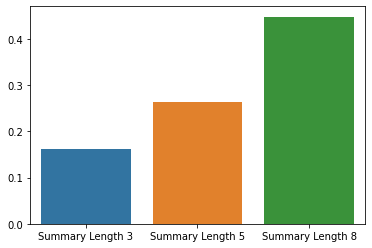

In [27]:
sns.barplot(f1_scores_names,f1_scores_one);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


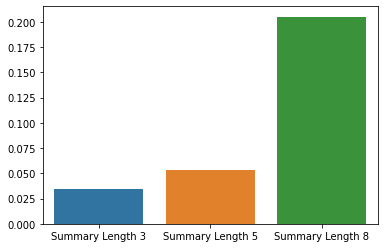

In [28]:
sns.barplot(f1_scores_names,f1_scores_two)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


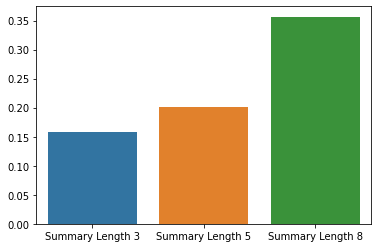

In [29]:
sns.barplot(f1_scores_names,f1_scores_l)

In [30]:
bleu_scores

[0.4347208719449914, 0.43741277066697004, 0.45966135761245924]

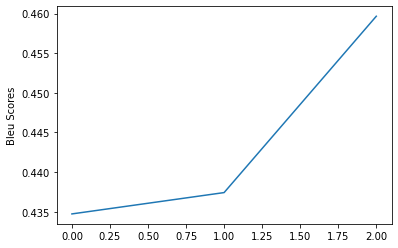

In [31]:
plt.plot(bleu_scores)
plt.ylabel('Bleu Scores')
plt.show()